In [72]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

# Exploring the data

## File Descriptions

This is a relational dataset from two systems. Each file is prefaced with the source (either air or hpg) to indicate its origin. Each restaurant has a unique **air_store_id** and **hpg_store_id**. Note that not all restaurants are covered by both systems, and that you have been provided data beyond the restaurants for which you must forecast. Latitudes and Longitudes are not exact to discourage de-identification of restaurants.

**air_reserve.csv**: This file contains reservations made in the air system. Note that the reserve_datetime indicates the time when the reservation was created, whereas the visit_datetime is the time in the future where the visit will occur.

**hpg_reserve.csv**: This file contains reservations made in the hpg system.

**air_store_info.csv**: This file contains information about select air restaurants. Column names and contents are self-explanatory.

**hpg_store_info.csv**: This file contains information about select hpg restaurants. Column names and contents are self-explanatory.

**store_id_relation.csv**: This file allows you to join select restaurants that have both the air and hpg system.

**air_visit_data.csv**: This file contains historical visit data for the air restaurants.

**sample_submission.csv**: This file shows a submission in the correct format, including the days for which you must forecast.

**date_info.csv**: This file gives basic information about the calendar dates in the dataset.

In [73]:


data = {
    'air_visit_data':
    pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/air_visit_data.csv.zip'),
    'air_store_info':
    pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/air_store_info.csv.zip'),
    'hpg_store_info':
    pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/hpg_store_info.csv.zip'),
    'air_reserve':
    pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/air_reserve.csv.zip'),
    'hpg_reserve':
    pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/hpg_reserve.csv.zip'),
    'store_id_relation':
    pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/store_id_relation.csv.zip'),
    'sample_submission':
    pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/sample_submission.csv.zip'),
    'date_info':
    pd.read_csv(f'{os.getenv("HOME")}/aiffel/kaggle_challenge1/date_info.csv.zip')
}


In [74]:
# taking a look at air_visit_data.csv
data["air_visit_data"].head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [75]:
# taking a look at air_store_info.csv
data["air_store_info"].head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [76]:
# taking a look at hpg_store_info.csv
data["hpg_store_info"].head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [77]:
# taking a look at air_reserve.csv
data["air_reserve"].head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [78]:
# taking a look at hpg_reserve.csv
data["hpg_reserve"].head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [79]:
# taking a look at store_id_relation.csv
data["store_id_relation"].head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [80]:
# taking a look at sample_submission.csv
data["sample_submission"].head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [81]:
# taking a look at date_info.csv
data["date_info"].head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [82]:
data["air_reserve"].air_store_id.nunique() # number of unique restaurants in air system


314

In [83]:
data["hpg_reserve"].hpg_store_id.nunique() # number of unique restaurants in hpg system


13325

In [84]:
data["store_id_relation"].air_store_id.nunique() # number of unique restaurants that are in both systems at once

150

### merge the data

before we merge air_reserve and hpg_reserve, we have to change the second column name to genre for both the tables. 


In [85]:
# # Rename some columns before merging
# air_store_info_column_change = data["air_store_info"]
# air_store_info_column_change = air_store_info_column_change.rename(columns={"air_genre_name": "genre_name"})
# hpg_store_info_column_change = data["hpg_store_info"]
# hpg_store_info_column_change = hpg_store_info_column_change.rename(columns={"hpg_genre_name": "genre_name"})
# hpg_store_info_column_change.head()

In [86]:
air = pd.merge(data["air_reserve"], data["air_store_info"], on='air_store_id')
air.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [87]:
hpg = pd.merge(data["hpg_reserve"], data["hpg_store_info"], on='hpg_store_id')
hpg.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
1,hpg_dac72789163a3f47,2016-01-02 12:00:00,2016-01-01 20:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
2,hpg_dac72789163a3f47,2016-01-03 19:00:00,2016-01-02 15:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
3,hpg_dac72789163a3f47,2016-01-06 12:00:00,2016-01-06 08:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
4,hpg_dac72789163a3f47,2016-01-10 17:00:00,2016-01-04 22:00:00,3,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698


In [94]:
print(data["air_visit_data"].air_store_id.nunique())
data["air_visit_data"].info()

829
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   air_store_id  252108 non-null  object
 1   visit_date    252108 non-null  object
 2   visitors      252108 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.8+ MB


In [71]:
# Merge tables

display(air.isnull().sum())
display(hpg.isnull().sum())

print('-------------------------------')

# full = pd.merge(air, data["store_id_relation"], how='left', on='air_store_id')
# hpg_rel = pd.merge(hpg,  data["store_id_relation"], how='left', on='hpg_store_id')

display(full.isnull().sum())
# display(hpg_rel.isnull().sum())

# print('-------------------------------')

# full = pd.merge(air_rel, hpg_rel, how='outer')

# print('-------------------------------')


# full["visit_date"] = 
# full = pd.merge(air_rel, hpg_rel, how='outer')


# display(full.isnull().sum())

air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
air_genre_name      0
air_area_name       0
latitude            0
longitude           0
dtype: int64

hpg_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
hpg_genre_name      0
hpg_area_name       0
latitude            0
longitude           0
dtype: int64

-------------------------------


air_store_id            0
visit_datetime          0
reserve_datetime        0
reserve_visitors        0
air_genre_name          0
air_area_name           0
latitude                0
longitude               0
hpg_store_id        56114
visit_year              0
visit_month             0
visit_date              0
visit_weekday           0
visit_time              0
reserve_year            0
reserve_month           0
reserve_date            0
reserve_weekday         0
reserve_time            0
store_id                0
store_genre_name        0
area_name               0
dtype: int64

In [65]:
print("In air reservations are: %d \nIn hpg reservations are: %d \nIn both systems at once there are: %d" % \
      (air.shape[0], hpg.shape[0], data["store_id_relation"].shape[0]))
print("So, totally must be: %d reservations." \
      % (full.shape[0]))

In air reservations are: 92378 
In hpg reservations are: 871308 
In both systems at once there are: 150
So, totally must be: 92378 reservations.


### changing date column



In [66]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92378 entries, 0 to 92377
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   air_store_id      92378 non-null  object        
 1   visit_datetime    92378 non-null  datetime64[ns]
 2   reserve_datetime  92378 non-null  datetime64[ns]
 3   reserve_visitors  92378 non-null  int64         
 4   air_genre_name    92378 non-null  object        
 5   air_area_name     92378 non-null  object        
 6   latitude          92378 non-null  float64       
 7   longitude         92378 non-null  float64       
 8   hpg_store_id      36264 non-null  object        
 9   visit_year        92378 non-null  int64         
 10  visit_month       92378 non-null  int64         
 11  visit_date        92378 non-null  int64         
 12  visit_weekday     92378 non-null  int64         
 13  visit_time        92378 non-null  object        
 14  reserve_year      9237

In [67]:
# Then we need to convert columns 'visit_datetime' and 'reserve_datetime' from object type -> to data/time type
full['visit_datetime'] = pd.to_datetime(full['visit_datetime'])
full['reserve_datetime'] = pd.to_datetime(full['reserve_datetime'])

full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92378 entries, 0 to 92377
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   air_store_id      92378 non-null  object        
 1   visit_datetime    92378 non-null  datetime64[ns]
 2   reserve_datetime  92378 non-null  datetime64[ns]
 3   reserve_visitors  92378 non-null  int64         
 4   air_genre_name    92378 non-null  object        
 5   air_area_name     92378 non-null  object        
 6   latitude          92378 non-null  float64       
 7   longitude         92378 non-null  float64       
 8   hpg_store_id      36264 non-null  object        
 9   visit_year        92378 non-null  int64         
 10  visit_month       92378 non-null  int64         
 11  visit_date        92378 non-null  int64         
 12  visit_weekday     92378 non-null  int64         
 13  visit_time        92378 non-null  object        
 14  reserve_year      9237

In [68]:
# Split converted date-time columns to year, month, date, day of week and time separate coluns of dataset
full['visit_year'] = pd.Series(full.visit_datetime.dt.year)
full['visit_month']  = pd.Series(full.visit_datetime.dt.month)
full['visit_date'] = pd.Series(full.visit_datetime.dt.day)
full['visit_weekday'] = pd.Series(full.visit_datetime.dt.weekday)
full['visit_time'] = pd.Series(full.visit_datetime.dt.time)

In [69]:
full['reserve_year'] = pd.Series(full.reserve_datetime.dt.year)
full['reserve_month']  = pd.Series(full.reserve_datetime.dt.month)
full['reserve_date'] = pd.Series(full.reserve_datetime.dt.day)
full['reserve_weekday'] = pd.Series(full.reserve_datetime.dt.weekday)
full['reserve_time'] = pd.Series(full.reserve_datetime.dt.time)

In [70]:
full.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,visit_year,...,visit_weekday,visit_time,reserve_year,reserve_month,reserve_date,reserve_weekday,reserve_time,store_id,store_genre_name,area_name
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,2016,...,4,19:00:00,2016,1,1,4,16:00:00,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,2016,...,4,20:00:00,2016,1,1,4,16:00:00,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,2016,...,5,18:00:00,2016,1,1,4,16:00:00,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,2016,...,5,21:00:00,2016,1,1,4,16:00:00,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,2016,...,4,21:00:00,2016,1,4,0,20:00:00,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen


### find NaNs

In [61]:
full.isnull().sum()

air_store_id            0
visit_datetime          0
reserve_datetime        0
reserve_visitors        0
air_genre_name          0
air_area_name           0
latitude                0
longitude               0
hpg_store_id        56114
visit_year              0
visit_month             0
visit_date              0
visit_weekday           0
visit_time              0
reserve_year            0
reserve_month           0
reserve_date            0
reserve_weekday         0
reserve_time            0
dtype: int64

In [62]:
# Fill NaNs to ease operations with ids and creation new columns
full['air_store_id'] = full['air_store_id'].fillna('0')
# full['hpg_store_id'] = full['hpg_store_id'].fillna('0')
full['air_genre_name'] = full['air_genre_name'].fillna('0')
# full['hpg_genre_name'] = full['hpg_genre_name'].fillna('0')

In [63]:
# Now lets put our data in order
# Create column 'store_id', where all ids from two sources will be collected together
full.loc[(full['air_genre_name'] != '0'), 'store_id'] = full['air_store_id']
# full.loc[(full['air_genre_name'] == '0'), 'store_id'] = full['hpg_store_id']

# Create column 'store_genre_name', where all genres of restaurants will be collected together
full.loc[(full['air_genre_name'] != '0'), 'store_genre_name'] = full['air_genre_name']
# full.loc[(full['air_genre_name'] == '0'), 'store_genre_name'] = full['hpg_genre_name']

# Create column 'air_hpg_link', to save connection between restaurants that are in both sources
# full.loc[(full['air_store_id'] != '0') & (full['hpg_genre_name'] != '0'), 'air_hpg_link'] = full['air_store_id']
# full.loc[(full['air_store_id'] != '0') & (full['hpg_genre_name'] == '0'), 'air_hpg_link'] = full['hpg_store_id']

# Create column 'store_genre_name', where all genres of restaurants will be collected together
full.loc[(full['air_genre_name'] != '0'), 'area_name'] = full['air_area_name']
# full.loc[(full['air_genre_name'] == '0'), 'area_name'] = full['hpg_area_name']

# full['air_hpg_link'] = full['air_hpg_link'].fillna('0')

In [64]:
full.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,visit_year,...,visit_weekday,visit_time,reserve_year,reserve_month,reserve_date,reserve_weekday,reserve_time,store_id,store_genre_name,area_name
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,2016,...,4,19:00:00,2016,1,1,4,16:00:00,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,2016,...,4,20:00:00,2016,1,1,4,16:00:00,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,2016,...,5,18:00:00,2016,1,1,4,16:00:00,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,2016,...,5,21:00:00,2016,1,1,4,16:00:00,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,2016,...,4,21:00:00,2016,1,4,0,20:00:00,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen


## data visualization


In [28]:
fullhist = full.groupby(['visit_datetime'],as_index=False).count().sort_values(by=['visit_datetime'])
fullhist_mnth = fullhist.loc[fullhist['visit_datetime'] <= pd.to_datetime('2016-02-01 23:59:00')]
fullhist_week = fullhist.loc[(fullhist['visit_datetime'] >= pd.to_datetime('2016-01-04 00:00:00')) 
                             & (fullhist['visit_datetime'] <= pd.to_datetime('2016-01-10 23:59:00'))]

In [29]:
fullhist.head()

,visit_datetime,air_store_id,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,...,visit_time,reserve_year,reserve_month,reserve_date,reserve_weekday,reserve_time,store_id,store_genre_name,air_hpg_link,area_name
0,2016-01-01 13:00:00,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2016-01-01 17:00:00,13,13,13,13,0,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
2,2016-01-01 18:00:00,25,25,25,25,0,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
3,2016-01-01 19:00:00,35,35,35,35,3,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
4,2016-01-01 20:00:00,9,9,9,9,2,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


In [30]:
fullhist_week.tail()

,visit_datetime,air_store_id,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,...,visit_time,reserve_year,reserve_month,reserve_date,reserve_weekday,reserve_time,store_id,store_genre_name,air_hpg_link,area_name
126,2016-01-10 19:00:00,304,304,304,304,16,304,304,304,304,...,304,304,304,304,304,304,304,304,304,304
127,2016-01-10 20:00:00,95,95,95,95,9,95,95,95,95,...,95,95,95,95,95,95,95,95,95,95
128,2016-01-10 21:00:00,42,42,42,42,0,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
129,2016-01-10 22:00:00,19,19,19,19,13,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
130,2016-01-10 23:00:00,4,4,4,4,1,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


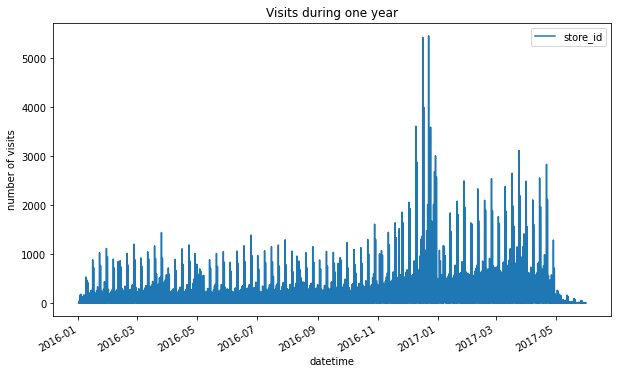

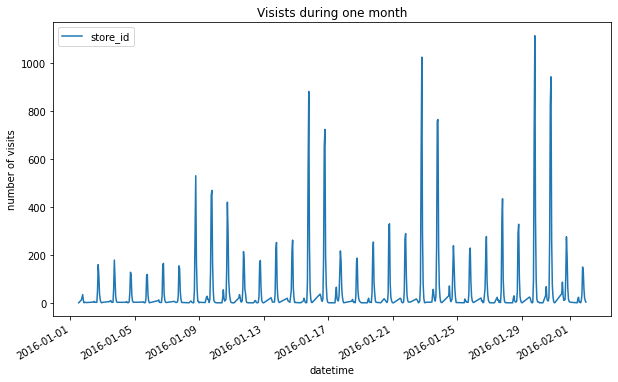

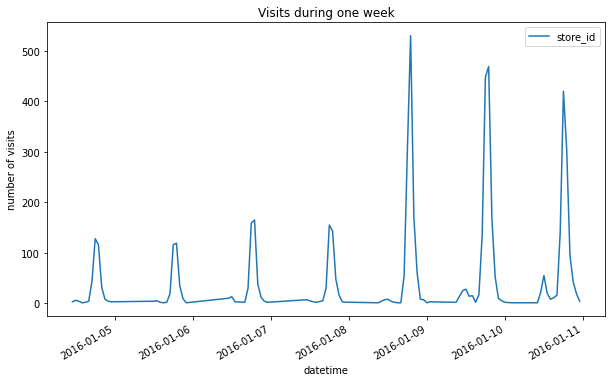

In [31]:
fullhist.plot(kind='line',
        x='visit_datetime', 
        y='store_id',
        title = 'Visits during one year',
        xlabel = 'datetime',
        ylabel = 'number of visits',        
        figsize=(10,6));

fullhist_mnth.plot(kind='line',
        x='visit_datetime', 
        y='store_id',
        title = 'Visists during one month',
        xlabel = 'datetime',
        ylabel = 'number of visits',        
        figsize=(10,6));

fullhist_week.plot(kind='line',
        x='visit_datetime', 
        y='store_id',
        title = 'Visits during one week',
        xlabel = 'datetime',
        ylabel = 'number of visits',        
        figsize=(10,6));


In [32]:
import datetime
import calendar
 
def findDay(date):
    born = datetime.datetime.strptime(date, '%Y-%m-%d').weekday()
    return (date + " = " + calendar.day_name[born])

In [33]:
fullhist_week

,visit_datetime,air_store_id,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,...,visit_time,reserve_year,reserve_month,reserve_date,reserve_weekday,reserve_time,store_id,store_genre_name,air_hpg_link,area_name
34,2016-01-04 11:00:00,3,3,3,3,0,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
35,2016-01-04 12:00:00,6,6,6,6,0,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
36,2016-01-04 13:00:00,4,4,4,4,0,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
37,2016-01-04 14:00:00,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
38,2016-01-04 15:00:00,2,2,2,2,1,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,2016-01-10 19:00:00,304,304,304,304,16,304,304,304,304,...,304,304,304,304,304,304,304,304,304,304
127,2016-01-10 20:00:00,95,95,95,95,9,95,95,95,95,...,95,95,95,95,95,95,95,95,95,95
128,2016-01-10 21:00:00,42,42,42,42,0,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
129,2016-01-10 22:00:00,19,19,19,19,13,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19


In [34]:
fullhist_date_unique = pd.DataFrame([datetime.date() for datetime in fullhist_week.visit_datetime])
fullhist_date_unique=fullhist_date_unique.rename(columns={0: "date"})
fullhist_date_unique.date.unique()

array([datetime.date(2016, 1, 4), datetime.date(2016, 1, 5),
       datetime.date(2016, 1, 6), datetime.date(2016, 1, 7),
       datetime.date(2016, 1, 8), datetime.date(2016, 1, 9),
       datetime.date(2016, 1, 10)], dtype=object)

In [35]:
for v in fullhist_date_unique.date.unique():
    
    print(findDay(str(v)))

2016-01-04 = Monday
2016-01-05 = Tuesday
2016-01-06 = Wednesday
2016-01-07 = Thursday
2016-01-08 = Friday
2016-01-09 = Saturday
2016-01-10 = Sunday


Friday Saturday and Sunday has the most visitors as assumed. So maybe it is good to add a column for day of the week. 


In [41]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 963686 entries, 0 to 963685
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   air_store_id      963686 non-null  object        
 1   visit_datetime    963686 non-null  datetime64[ns]
 2   reserve_datetime  963686 non-null  datetime64[ns]
 3   air_genre_name    963686 non-null  object        
 4   air_area_name     92378 non-null   object        
 5   latitude          963686 non-null  float64       
 6   longitude         963686 non-null  float64       
 7   hpg_store_id      963686 non-null  object        
 8   hpg_genre_name    963686 non-null  object        
 9   hpg_area_name     871308 non-null  object        
 10  visit_year        963686 non-null  int64         
 11  visit_month       963686 non-null  int64         
 12  visit_date        963686 non-null  int64         
 13  visit_weekday     963686 non-null  int64         
 14  visi

In [42]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)


models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]


def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

y_pred = AveragingBlending(models, x, y, data["sample_submission"])
print(len(y_pred))
y_pred

ValueError: could not convert string to float: 'air_877f79706adbfb06'